In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
!wget https://storage.googleapis.com/applied-dl/mini_flowers.zip \
    -O /tmp/mini_flowers.zip


/Desktop/tmp/mini_flowers.zip: No such file or directory


In [0]:
!ls /tmp

cats_and_dogs_filtered.zip  LICENSE.txt  mini_flowers.zip  train  val


In [0]:
local_zip = '/tmp/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
!ls /tmp

cats_and_dogs_filtered.zip  LICENSE.txt  mini_flowers.zip  train  val


In [0]:
!ls /tmp/train


daisy  dandelion  roses  sunflowers  tulips


In [0]:
base_dir = '/tmp'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_daisy_dir = os.path.join(train_dir, 'daisy')
train_dandelion_dir = os.path.join(train_dir, 'dandelion')
train_roses_dir = os.path.join(train_dir, 'roses')
train_sunflowers_dir = os.path.join(train_dir, 'sunflowers')
train_tulips_dir = os.path.join(train_dir, 'tulips')

validation_daisy_dir = os.path.join(validation_dir, 'daisy')
validation_dandelion_dir = os.path.join(validation_dir, 'dandelion')
validation_roses_dir = os.path.join(validation_dir, 'roses')
validation_sunflowers_dir = os.path.join(validation_dir, 'sunflowers')
validation_tulips_dir = os.path.join(validation_dir, 'tulips')



In [0]:
num_daisy_tr = len(os.listdir(train_daisy_dir))
num_dandelion_tr = len(os.listdir(train_dandelion_dir))
num_roses_tr = len(os.listdir(train_roses_dir))
num_sunflowers_tr = len(os.listdir(train_sunflowers_dir))
num_tulips_tr = len(os.listdir(train_tulips_dir))

num_daisy_val = len(os.listdir(validation_daisy_dir))
num_dandelion_val = len(os.listdir(validation_dandelion_dir))
num_roses_val = len(os.listdir(validation_roses_dir))
num_sunflowers_val = len(os.listdir(validation_sunflowers_dir))
num_tulips_val = len(os.listdir(validation_tulips_dir))

total_train = num_daisy_tr + num_dandelion_tr + num_roses_tr + num_sunflowers_tr + num_tulips_tr
total_val = num_daisy_val + num_dandelion_val + num_roses_val + num_sunflowers_val + num_tulips_val

In [0]:
print('Training daisy images:', num_daisy_tr)
print('Training dandelion images:', num_dandelion_tr)
print('Training roses images:', num_roses_tr)
print('Training sunflowers images:', num_sunflowers_tr)
print('Training tulips images:', num_tulips_tr)

print('Validation daisy images:', num_daisy_val)
print('Validation dandelion images:', num_dandelion_val)
print('Validation roses images:', num_roses_val)
print('Validation sunflowers images:', num_sunflowers_val)
print('Validation tulips images:', num_tulips_val)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training daisy images: 200
Training dandelion images: 200
Training roses images: 200
Training sunflowers images: 200
Training tulips images: 200
Validation daisy images: 100
Validation dandelion images: 100
Validation roses images: 100
Validation sunflowers images: 100
Validation tulips images: 100
--
Total training images: 1000
Total validation images: 500


In [0]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
TARGET_SHAPE = 150 
BATCH_SIZE = 32

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))

In [0]:
EPOCHS = 50


In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))


Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.7923 - acc: 0.3460 - val_loss: 1.0136 - val_acc: 0.6200
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.1254 - acc: 0.5780 - val_loss: 0.8488 - val_acc: 0.7060
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9103 - acc: 0.6400 - val_loss: 0.7882 - val_acc: 0.6840
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7827 - acc: 0.7130 - val_loss: 0.6983 - val_acc: 0.7440
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6664 - acc: 0.7450 - val_loss: 0.6312 - val_acc: 0.7720
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.5601 - acc: 0.8010 - val_loss: 0.6119 - val_acc: 0.7860
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.4392 - acc: 0.8460 - val_loss: 0.5917 - val_acc: 0.7740
E

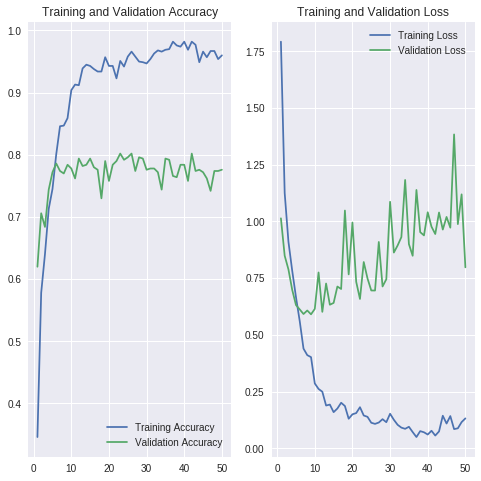

In [0]:

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Question2.  Base -----**[VGG19](https://)**

In [0]:
conv_base = VGG19(weights='imagenet',include_top=False, input_shape=(150, 150, 3))


80142336/80134624 [==============================] - 2s 0us/step


In [0]:
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
TARGET_SHAPE = 150 
BATCH_SIZE = 32

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))

In [0]:
EPOCHS = 50


In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.8744 - acc: 0.3340 - val_loss: 1.0726 - val_acc: 0.6600
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.2780 - acc: 0.5060 - val_loss: 0.8942 - val_acc: 0.6960
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.0263 - acc: 0.6040 - val_loss: 0.8216 - val_acc: 0.7400
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9181 - acc: 0.6420 - val_loss: 0.8007 - val_acc: 0.7460
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.7660 - acc: 0.7030 - val_loss: 0.6792 - val_acc: 0.7740
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6717 - acc: 0.7260 - val_loss: 0.6871 - val_acc: 0.7400
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6228 - acc: 0.7600 - val_loss: 0.6278 - val_acc: 0.7700
E

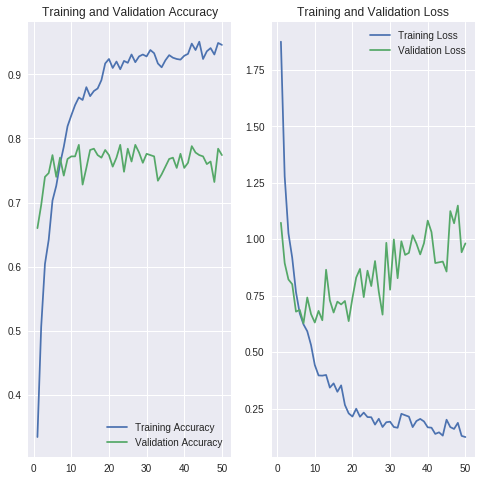

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Base2 - ResNet50

In [0]:
conv_base = ResNet50(weights='imagenet',include_top=False, input_shape=(150, 150, 3))


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
conv_base.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
TARGET_SHAPE = 150 
BATCH_SIZE = 32

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
FLATTENED_SHAPE = 5 * 5 * 2048

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))

In [0]:
EPOCHS = 50

In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 8s 8ms/sample - loss: 2.5472 - acc: 0.1830 - val_loss: 1.8921 - val_acc: 0.2200
Epoch 2/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 1.8608 - acc: 0.2050 - val_loss: 1.7009 - val_acc: 0.2340
Epoch 3/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 1.8347 - acc: 0.1860 - val_loss: 1.6889 - val_acc: 0.2580
Epoch 4/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 1.7894 - acc: 0.1840 - val_loss: 1.6316 - val_acc: 0.2860
Epoch 5/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 1.7384 - acc: 0.2050 - val_loss: 1.6383 - val_acc: 0.3420
Epoch 6/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 1.7172 - acc: 0.2190 - val_loss: 1.6492 - val_acc: 0.2880
Epoch 7/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 1.6973 - acc: 0.2310 - val_loss: 1.6616 - val_acc: 0.2560
E

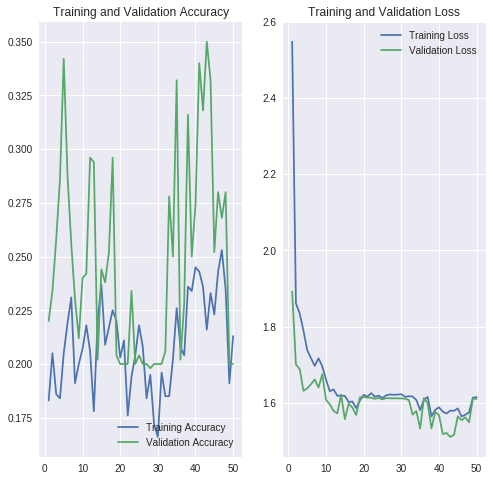

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Conclusion : 
1. I have used three preTrain base - VGG16 , VGG19 and ResNet50. 
2.  from the above result shows that VGG16 has less parameter and high accuracy 